# Importar bibliotecas

In [1]:
import pandas as pd 
from pandas.tseries.offsets import DateOffset
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Puxar dataframes

In [2]:
#Base tabela Car_Price
car_price_df = pd.read_csv("Database/pos/car_price_prediction.csv")
# Base histórica do real perante o dólar
dxy_df = pd.read_csv("Database/pos/Índice Dólar Dados Históricos.csv", decimal=',')

In [3]:
car_price_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
dxy_df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.12.2020,89.94,91.94,91.94,89.52,NaN,"-2,10%"
1,01.11.2020,91.87,93.89,94.30,91.51,NaN,"-2,31%"
2,01.10.2020,94.04,93.80,94.10,92.47,NaN,"0,16%"
3,01.09.2020,93.89,92.18,94.74,91.75,NaN,"1,89%"
4,01.08.2020,92.14,93.46,93.99,91.99,NaN,"-1,29%"


# Feature Engineering

## Tratamento dos dados tabela car_price

In [5]:
car_price_df['Engine volume'].tail()

19232    2.0 Turbo
19233          2.4
19234            2
19235            2
19236          2.4
Name: Engine volume, dtype: object

In [6]:
car_price_df['Mileage'] = car_price_df['Mileage'].str.replace('km', '').astype(float)

In [7]:
car_price_df['Levy'] = car_price_df['Levy'].replace({'-':np.nan}).astype(float)

In [8]:
car_price_df['Exist_Turbo'] = car_price_df['Engine volume'].str.contains('Turbo')

In [9]:
car_price_df['Exist_Turbo'].head()

0    False
1    False
2    False
3    False
4    False
Name: Exist_Turbo, dtype: bool

In [10]:
car_price_df['Engine volume'] = car_price_df['Engine volume'].str.replace(' Turbo', '').astype(float)

In [11]:
car_price_df['Doors'].tail()

19232    02-Mar
19233    04-May
19234    04-May
19235    04-May
19236    04-May
Name: Doors, dtype: object

In [12]:
l1 = list(set(car_price_df['Doors']))
l2 = [2,5,4]

replacement_map = {str(i1): int(i2) for i1, i2 in zip(l1, l2)}
car_price_df['Doors'] = car_price_df['Doors'].map(replacement_map)

In [13]:
car_price_df['Doors'].tail()

19232    5
19233    2
19234    2
19235    2
19236    2
Name: Doors, dtype: int64

In [14]:
car_price_df.columns = ['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod_year',
       'Category', 'Leather_interior', 'Fuel_type', 'Engine_volume', 'Mileage',
       'Cylinders', 'Gear_box_type', 'Drive_wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'Exist_Turbo']

## Tratamento dos dados tabela DXY (indice dólar)

In [15]:
dxy_df['date'] = pd.to_datetime(dxy_df['Data'], dayfirst=True)

In [16]:
dxy_df['Year'] = dxy_df['date'].dt.year

In [17]:
dxy_df.drop(columns='Data', inplace=True)

In [18]:
dxy_df.columns = ['last_price', 'open_price', 'max_price', 'min_price', 'volume', 'var_%', 'date', 'Year']

In [19]:
dxy_df['var_%']=dxy_df['var_%'].str.replace('%', '')
dxy_df['var_%']=dxy_df['var_%'].str.replace(',', '.').astype(float)

In [20]:
dxy_year_df = dxy_df.groupby('Year').last_price.mean().reset_index()

## Unificação da base

In [21]:
union_df = car_price_df.merge(dxy_year_df, left_on='Prod_year', right_on='Year', how='left')

In [22]:
union_df.drop(columns='Year', inplace=True)

In [23]:
union_df.head(2)

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Exist_Turbo,last_price
0,45654403,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,2,Left wheel,Silver,12,False,81.3600
1,44731507,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,2,Left wheel,Black,8,False,76.1375


## Analise de dados duplicados

In [24]:
print(union_df['ID'].duplicated().sum())
union_df.ID.value_counts().head()

313


45815365    8
45815361    8
45815363    7
45815368    7
45723475    7
Name: ID, dtype: int64

In [25]:
union_df.query("ID == 45815361")

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Exist_Turbo,last_price
1286,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
3919,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
6871,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
11499,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
13065,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
14637,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
17204,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333
18968,45815361,14113,NaN,TOYOTA,Aqua,2013,Hatchback,No,Hybrid,1.5,100000.0,4.0,Variator,Front,2,Right-hand drive,White,6,False,81.433333


In [26]:
# Shape antes
union_df.shape

(19237, 20)

In [27]:
#Shape depois
union_df.drop_duplicates('ID', inplace=True)
union_df.shape

(18924, 20)

## Tratamento de Null value

In [28]:
union_df.isnull().sum()

ID                     0
Price                  0
Levy                5709
Manufacturer           0
Model                  0
Prod_year              0
Category               0
Leather_interior       0
Fuel_type              0
Engine_volume          0
Mileage                0
Cylinders              0
Gear_box_type          0
Drive_wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
Exist_Turbo            0
last_price            15
dtype: int64

### Tratando LEVY

#### Método Implace KNN

In [29]:
# Número de linhas com esse critério nulo chega a 30,16% do DF

In [30]:
union_df.Levy.isnull().sum()/len(union_df)

0.30168040583386174

In [31]:
#Levy - correlação com os atributos numéricos

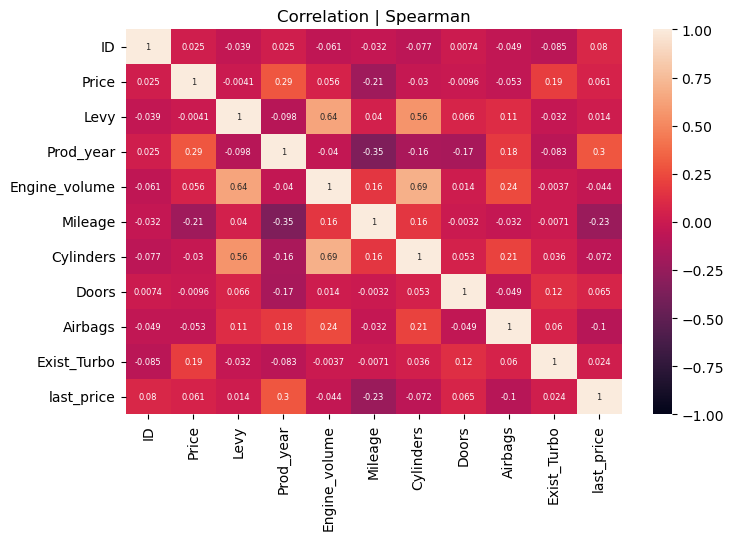

In [32]:
corr = union_df.corr(method='spearman')
plt.figure(figsize = (8,5))
plt.title(f'Correlation | Spearman')
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, annot_kws={"size":6})
plt.show()

As variáveis numpericas pertinentes para o impacto do Levy são:

    - Engine_volume
    - Cylinders
     
    

In [33]:
# Preechimento via KNN

In [34]:
param = ['Engine_volume', 'Cylinders', 'Levy']

In [35]:
from sklearn.impute import KNNImputer
from sklearn import metrics

# Aplicação
df_fill_levy = union_df[param].copy()

imputer_KNN = KNNImputer()
df_KNN = imputer_KNN.fit_transform(df_fill_levy)
imputer_KNN_imputed = pd.DataFrame(df_KNN, columns=param)

print("ESTATÍSTICA DF ORIGINAL")
print(f"{df_fill_levy.Levy.describe()} \n")
print("ESTATÍSTICA DF COM PREENCHIMENTO")
print(imputer_KNN_imputed.Levy.describe())

union_df_knn = union_df.copy()

# Substituição da coluna preenchida no DF original
union_df_knn['Levy'] = list(imputer_KNN_imputed['Levy'])

ESTATÍSTICA DF ORIGINAL
count    13215.000000
mean       906.299205
std        463.296871
min         87.000000
25%        640.000000
50%        781.000000
75%       1058.000000
max      11714.000000
Name: Levy, dtype: float64 

ESTATÍSTICA DF COM PREENCHIMENTO
count    18924.000000
mean       936.291270
std        479.966682
min         87.000000
25%        691.600000
50%        831.000000
75%       1053.000000
max      11714.000000
Name: Levy, dtype: float64


#### Método Dropna()

In [36]:
union_df_drop = union_df.copy()

In [37]:
union_df_drop.dropna(axis=0, inplace=True)

### Tratando DXY

In [38]:
union_df_knn.isnull().sum()

ID                   0
Price                0
Levy                 0
Manufacturer         0
Model                0
Prod_year            0
Category             0
Leather_interior     0
Fuel_type            0
Engine_volume        0
Mileage              0
Cylinders            0
Gear_box_type        0
Drive_wheels         0
Doors                0
Wheel                0
Color                0
Airbags              0
Exist_Turbo          0
last_price          15
dtype: int64

In [39]:
# Devido ao pequeno número e dos dados serem de carros muito antigos, foi usado dropna para excluir as 15 linhas.

In [40]:
union_df_knn.dropna(axis=0, inplace=True)

In [41]:
union_df_knn.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod_year           0
Category            0
Leather_interior    0
Fuel_type           0
Engine_volume       0
Mileage             0
Cylinders           0
Gear_box_type       0
Drive_wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
Exist_Turbo         0
last_price          0
dtype: int64

## Tratamento de Outliers

In [42]:
cat_features = ['Manufacturer', 'Model','Category','Leather_interior', 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color', 'Exist_Turbo']
num_features = ['Price','Levy','Prod_year','Engine_volume','Mileage','Cylinders','Doors','Airbags','Age','Mileage_per_Age','last_price']

### Tratamento target

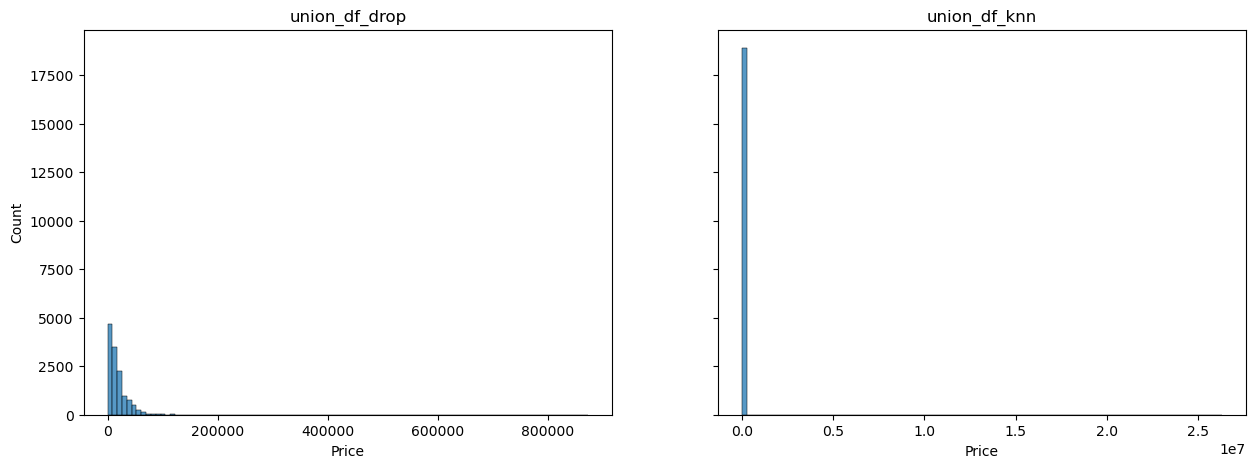

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.histplot(data=union_df_drop, x='Price', bins=100, ax=ax1)
ax1.set_title("union_df_drop")
sns.histplot(data=union_df_knn, x='Price', bins=100, ax=ax2)
ax2.set_title("union_df_knn")
plt.show()

In [44]:
q1 = union_df_knn.Price.quantile(0.25)
q3 = union_df_knn.Price.quantile(0.75)
IQR = q3 - q1
union_df_knn = union_df_knn[~((union_df_knn.Price < (q1 - 1.5 * IQR)) |(union_df_knn.Price > (q3 + 1.5 * IQR)))]

q1 = union_df_drop.Price.quantile(0.25)
q3 = union_df_drop.Price.quantile(0.75)
IQR = q3 - q1
union_df_drop = union_df_drop[~((union_df_drop.Price < (q1 - 1.5 * IQR)) |(union_df_drop.Price > (q3 + 1.5 * IQR)))]

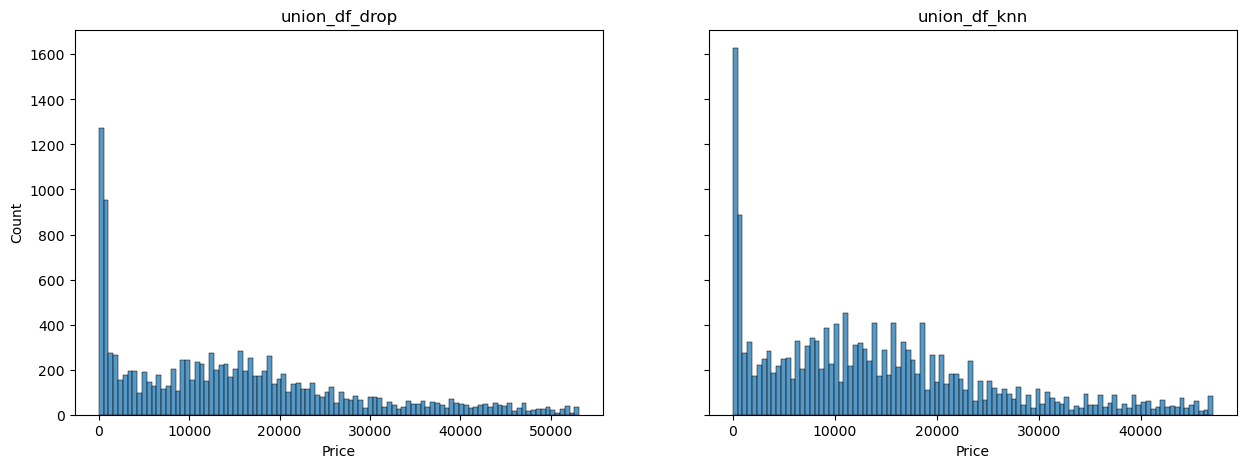

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,5))
sns.histplot(data=union_df_drop, x='Price', bins=100, ax=ax1)
ax1.set_title("union_df_drop")
sns.histplot(data=union_df_knn, x='Price', bins=100, ax=ax2)
ax2.set_title("union_df_knn")
plt.show()

### Dummies

Metodo de clusterização (Análise multivariada)
- Testar inicialmente KNN

In [46]:
cat_features = ['Manufacturer', 'Model','Category','Leather_interior', 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color', 'Exist_Turbo']
num_features = ['Price','Levy','Prod_year','Engine_volume','Mileage','Cylinders','Doors','Airbags','Age','Mileage_per_Age','last_price']

In [47]:
for col in cat_features:
    print(f"{col} - {union_df[cat_features][col].nunique()}")

Manufacturer - 65
Model - 1590
Category - 11
Leather_interior - 2
Fuel_type - 7
Gear_box_type - 4
Drive_wheels - 3
Wheel - 2
Color - 16
Exist_Turbo - 2


In [48]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def dummies(df_union): 
    df = df_union.copy()
    # Encode labels 
    df['Manufacturer']= le.fit_transform(df['Manufacturer']) 
    df['Model']= le.fit_transform(df['Model']) 
    df['Color']= le.fit_transform(df['Color'])
    # Outras colunas categóricas
    df = pd.get_dummies(df)
    return df

In [49]:
df_dummies_drop = dummies(union_df_drop)
df_dummies_knn = dummies(union_df_knn)

### KNN

In [50]:
from pyod.models.knn import KNN

In [51]:
def knn_outliers(df_dummies, df_orig):
    x = df_dummies.drop(columns=['ID'], axis=1).copy()
    
    # Treinar KNN
    clf = KNN()
    clf.fit(x) 
    # Obter labels e número de outliers                               
    y = clf.labels_ # binary labels (0: inliers, 1: outliers) 
    #Saídas
    print(np.unique(y, return_counts=True))
    print(f"Shape antes:{df_orig.shape}")
    
    outliers = []
    for i in range(len(y)):
        if y[i] == 1:
            outliers.append(i)
            
    outliers_df = df_orig.iloc[outliers,:]
    df_without_outliers = df_orig.drop(outliers_df.index)
    
    print(f"Shape depois:{df_without_outliers.shape}")
    return df_without_outliers

In [52]:
df_without_outliers_knn = knn_outliers(df_dummies_knn, union_df_knn)

(array([0, 1]), array([16072,  1786], dtype=int64))
Shape antes:(17858, 20)
Shape depois:(16072, 20)


In [53]:
df_without_outliers_drop = knn_outliers(df_dummies_drop, union_df_drop)

(array([0, 1]), array([11428,  1270], dtype=int64))
Shape antes:(12698, 20)
Shape depois:(11428, 20)


# Análise Descritiva

In [54]:
list(df_without_outliers_drop.select_dtypes([int, float]).columns)

['ID',
 'Price',
 'Levy',
 'Prod_year',
 'Engine_volume',
 'Mileage',
 'Cylinders',
 'Doors',
 'Airbags',
 'last_price']

## Análise de features    

In [55]:
# #prod = list(set(df_without_outliers.produto))

# cols_pairplot = list(df_without_outliers.select_dtypes([int, float]).columns)

# df_plot = df_without_outliers.copy()
# #df_plot = df_plot.loc[df_plot.produto.isin(prod)]

# sns.pairplot(data = df_plot, vars = cols_pairplot, corner = True, diag_kind = 'kde')
# plt.show();

### Numerical

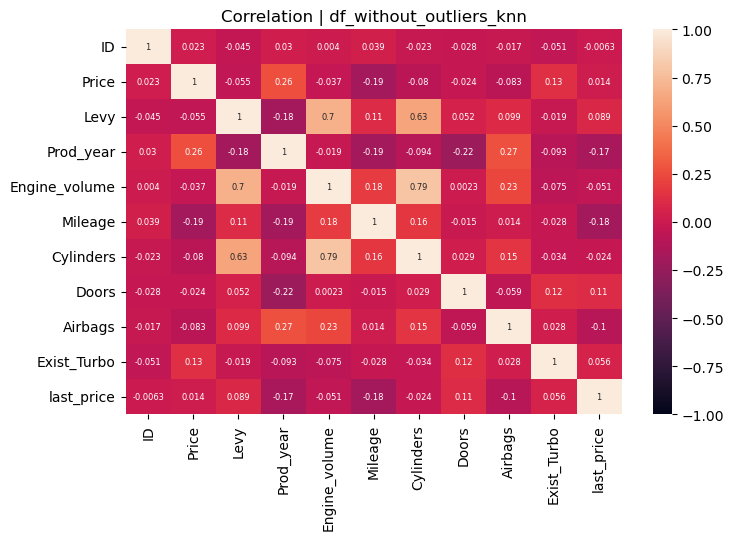

In [56]:
corr =df_without_outliers_knn.corr(method='pearson')
plt.figure(figsize = (8,5))
plt.title(f'Correlation | df_without_outliers_knn')
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, annot_kws={"size":6})
plt.show()

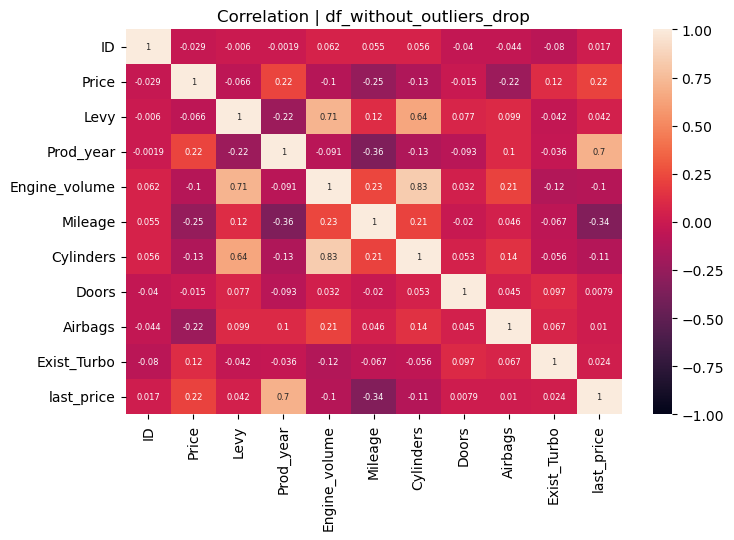

In [57]:
corr =df_without_outliers_drop.corr(method='pearson')
plt.figure(figsize = (8,5))
plt.title(f'Correlation | df_without_outliers_drop')
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, annot_kws={"size":6})
plt.show()

### Categorical

P-Value para variavel Manufacturer é:  {0.0}


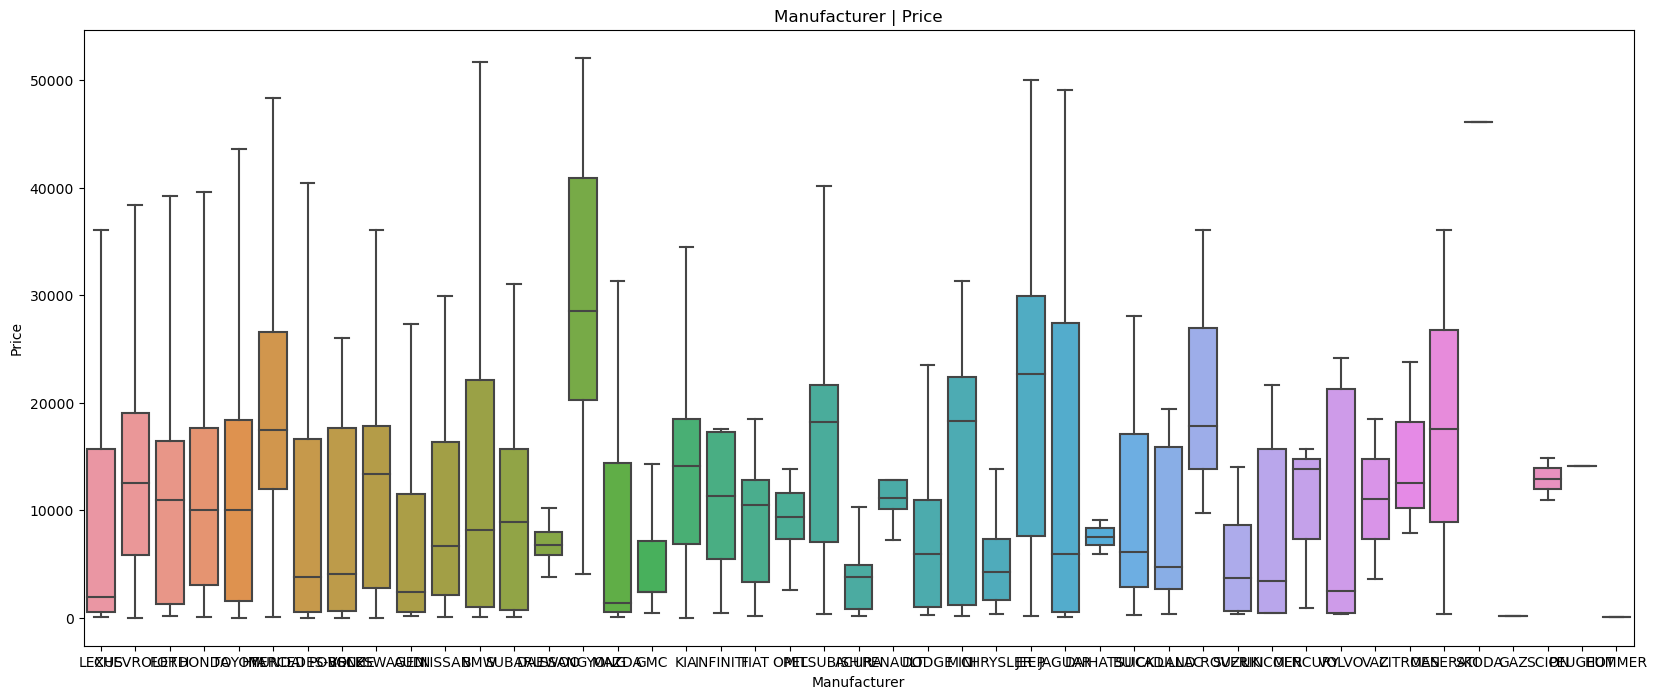

P-Value para variavel Model é:  {0.0}


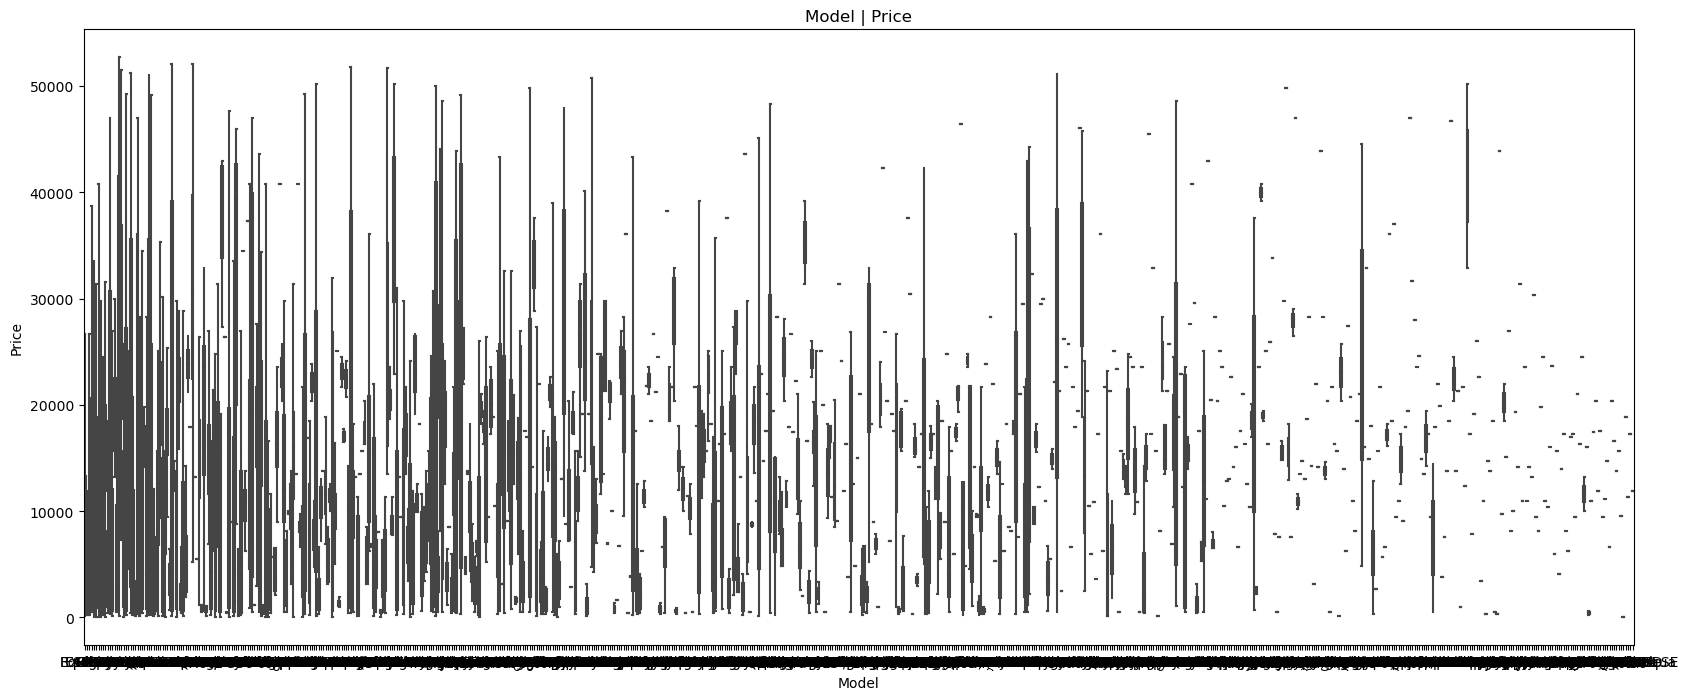

P-Value para variavel Category é:  {9.036511766005489e-201}


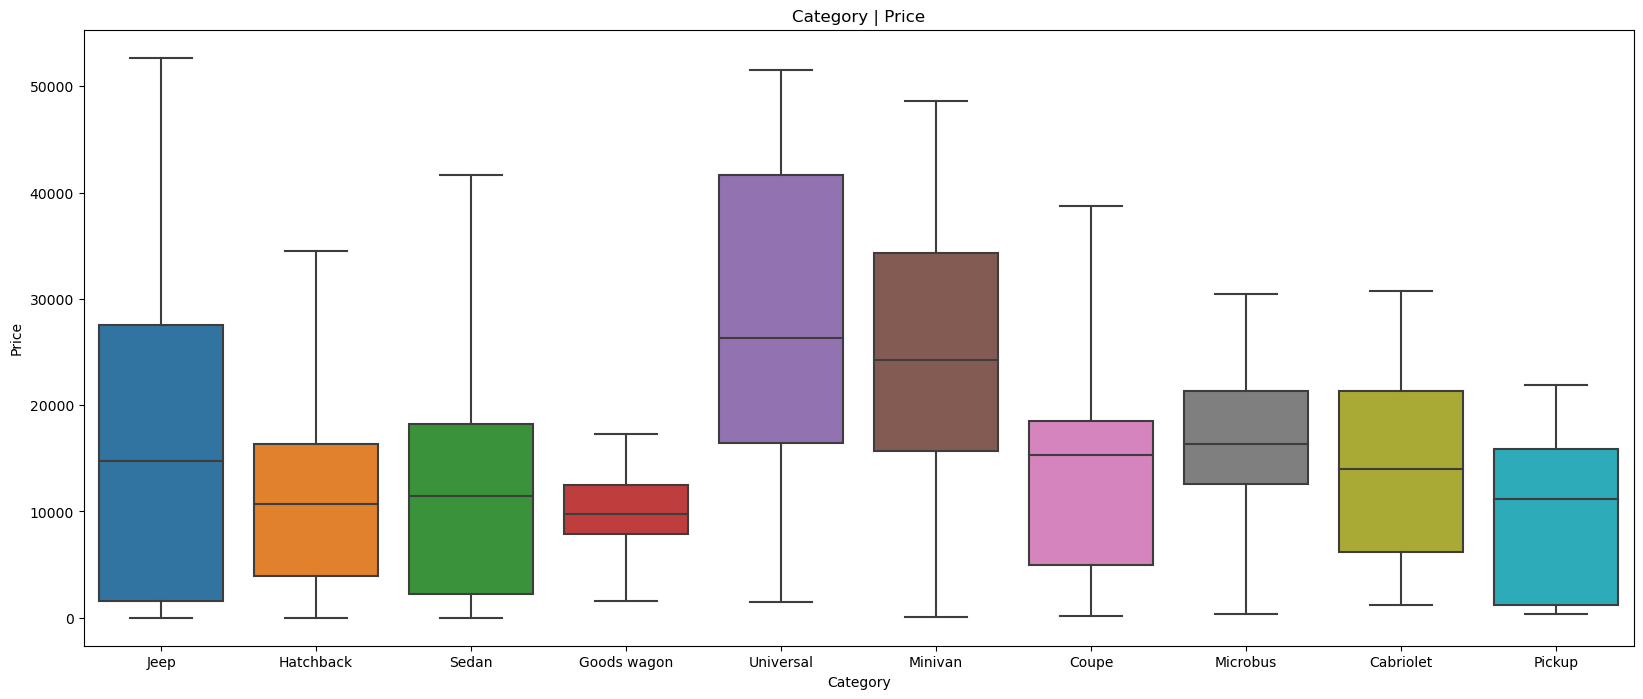

P-Value para variavel Leather_interior é:  {8.940577672633194e-09}


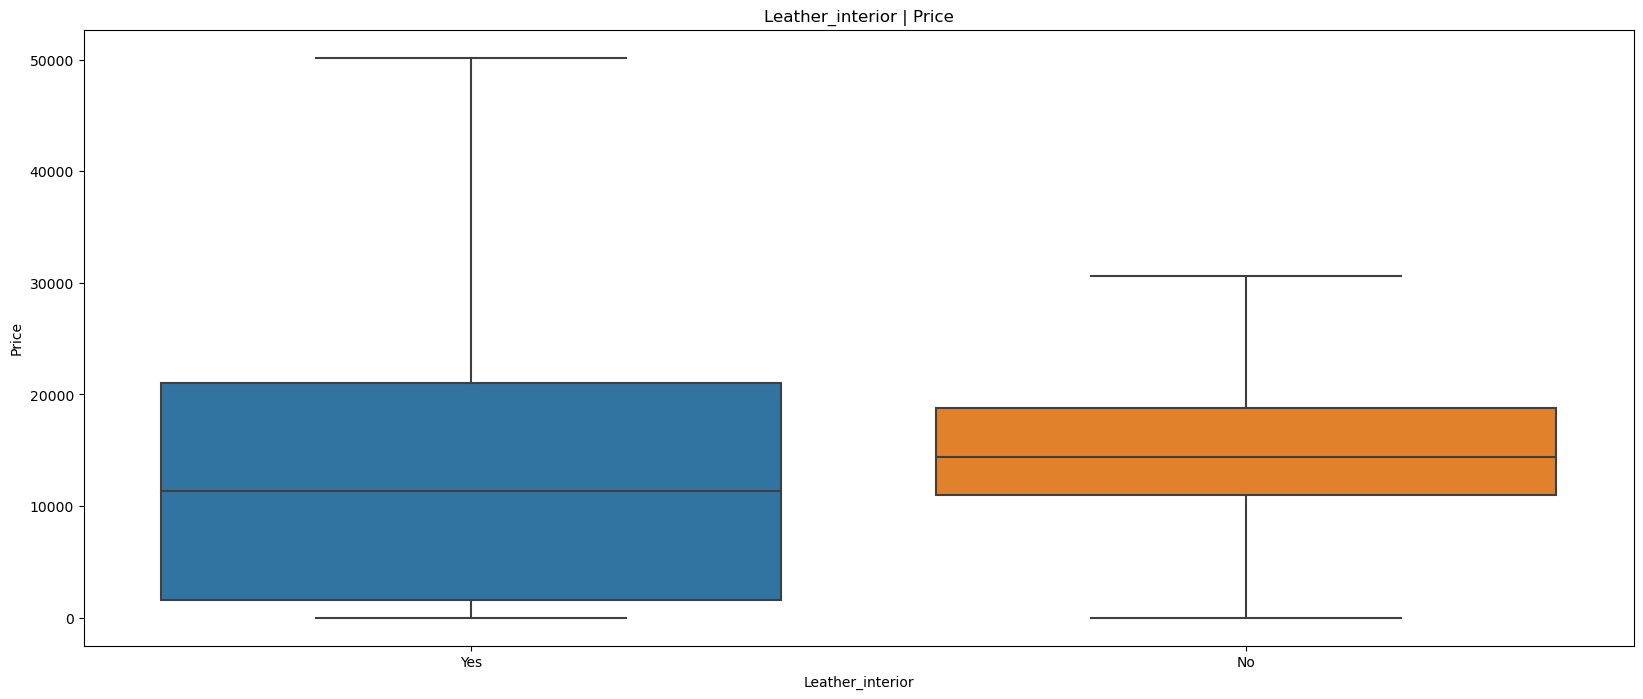

P-Value para variavel Fuel_type é:  {1.8762064104744488e-300}


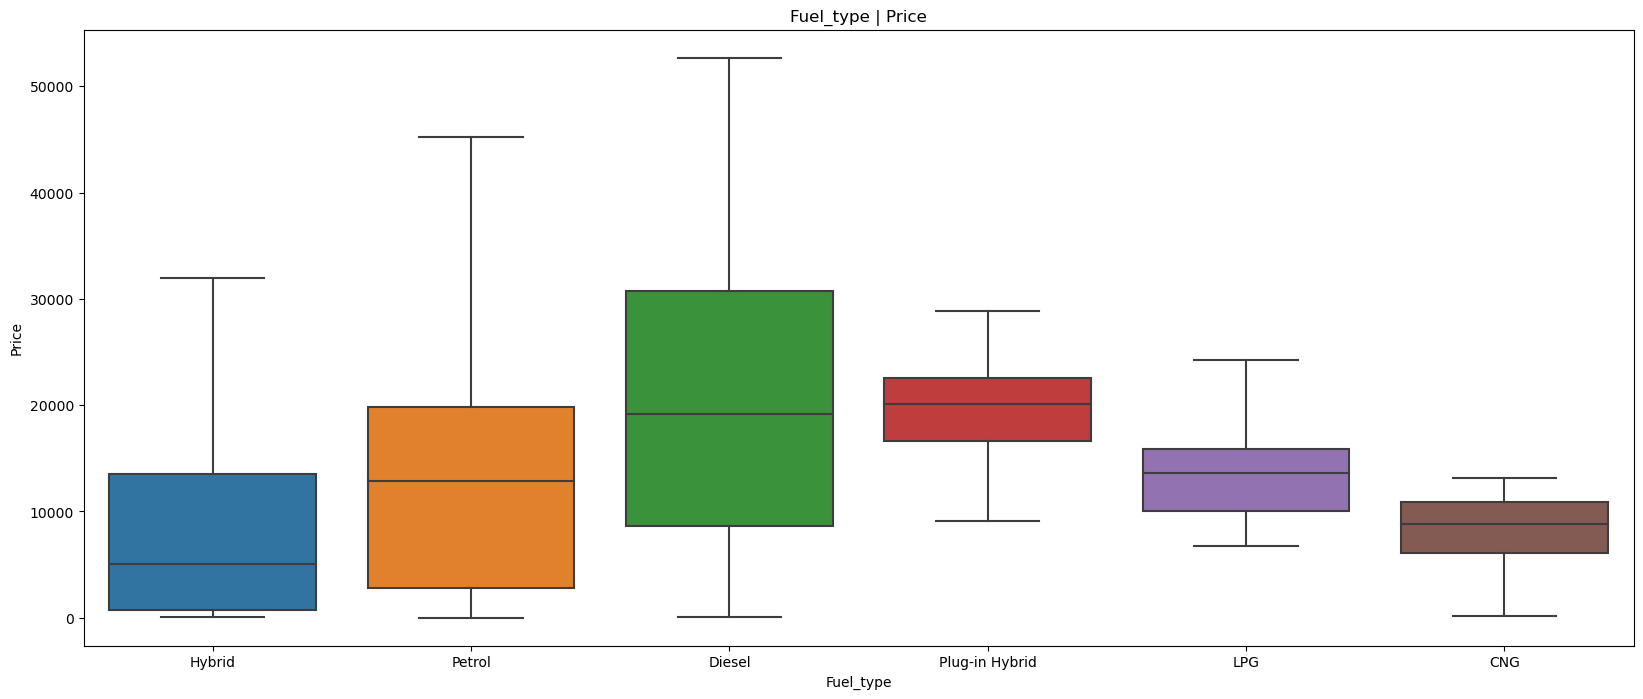

P-Value para variavel Gear_box_type é:  {6.820932934398122e-79}


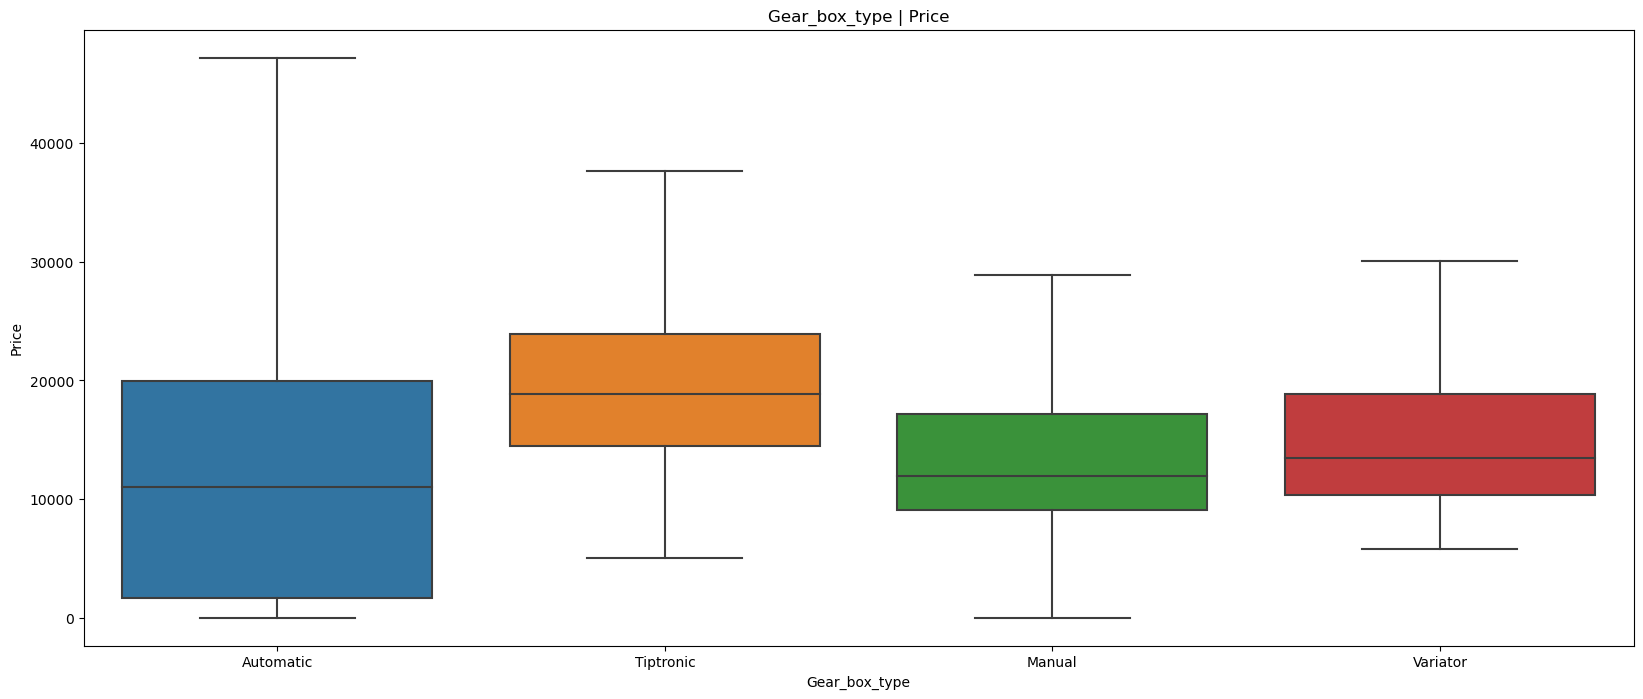

P-Value para variavel Drive_wheels é:  {2.4986467416718592e-54}


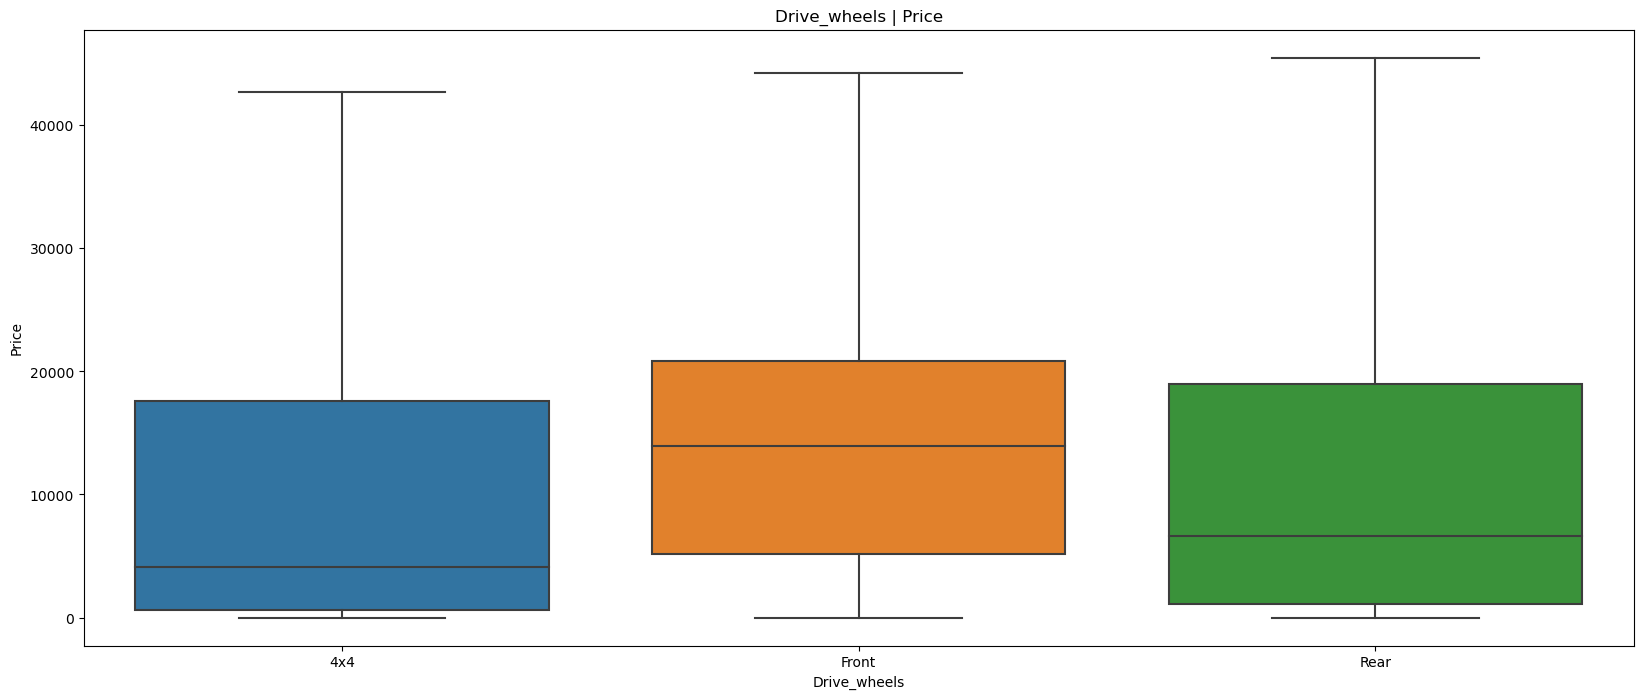

P-Value para variavel Wheel é:  {2.8760502238479326e-07}


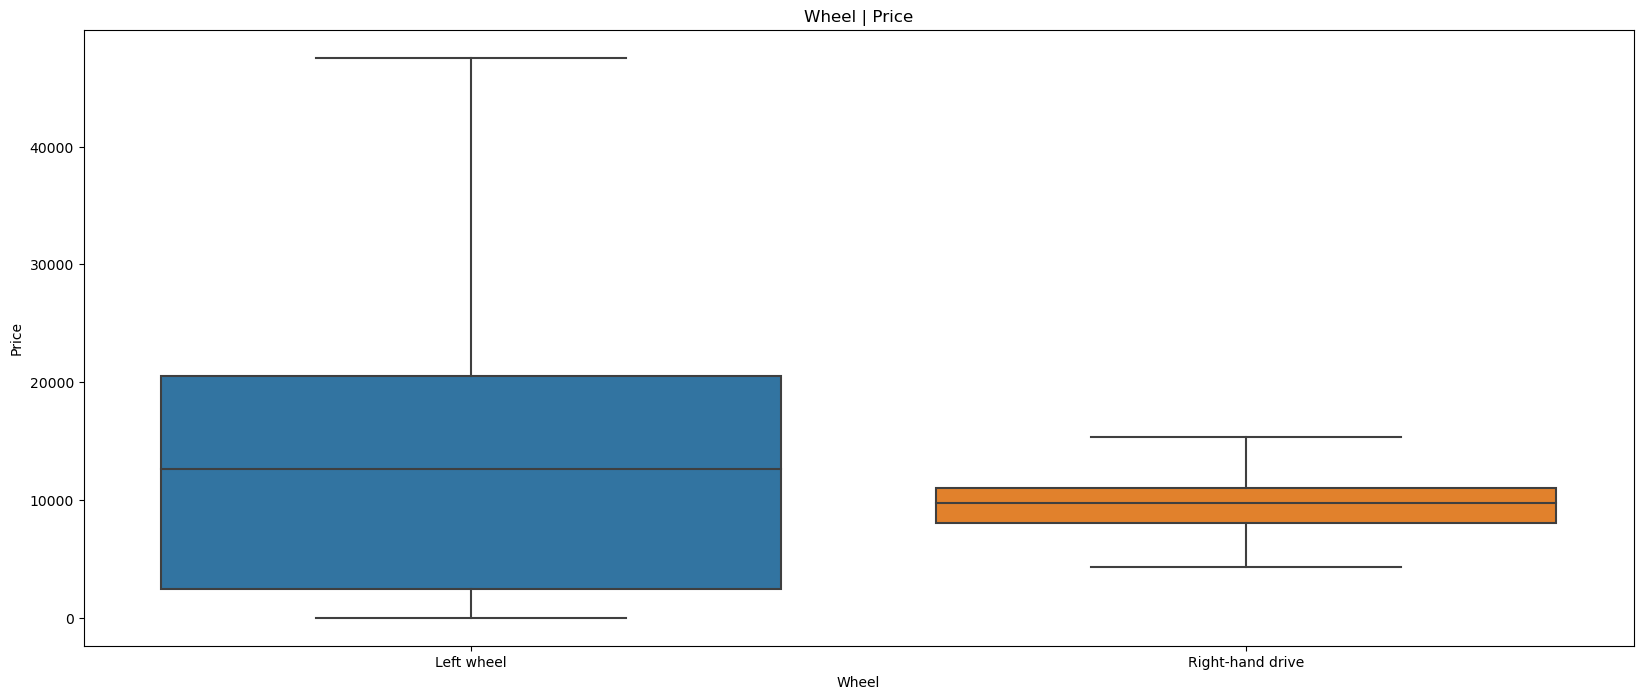

P-Value para variavel Color é:  {2.7678247475445093e-10}


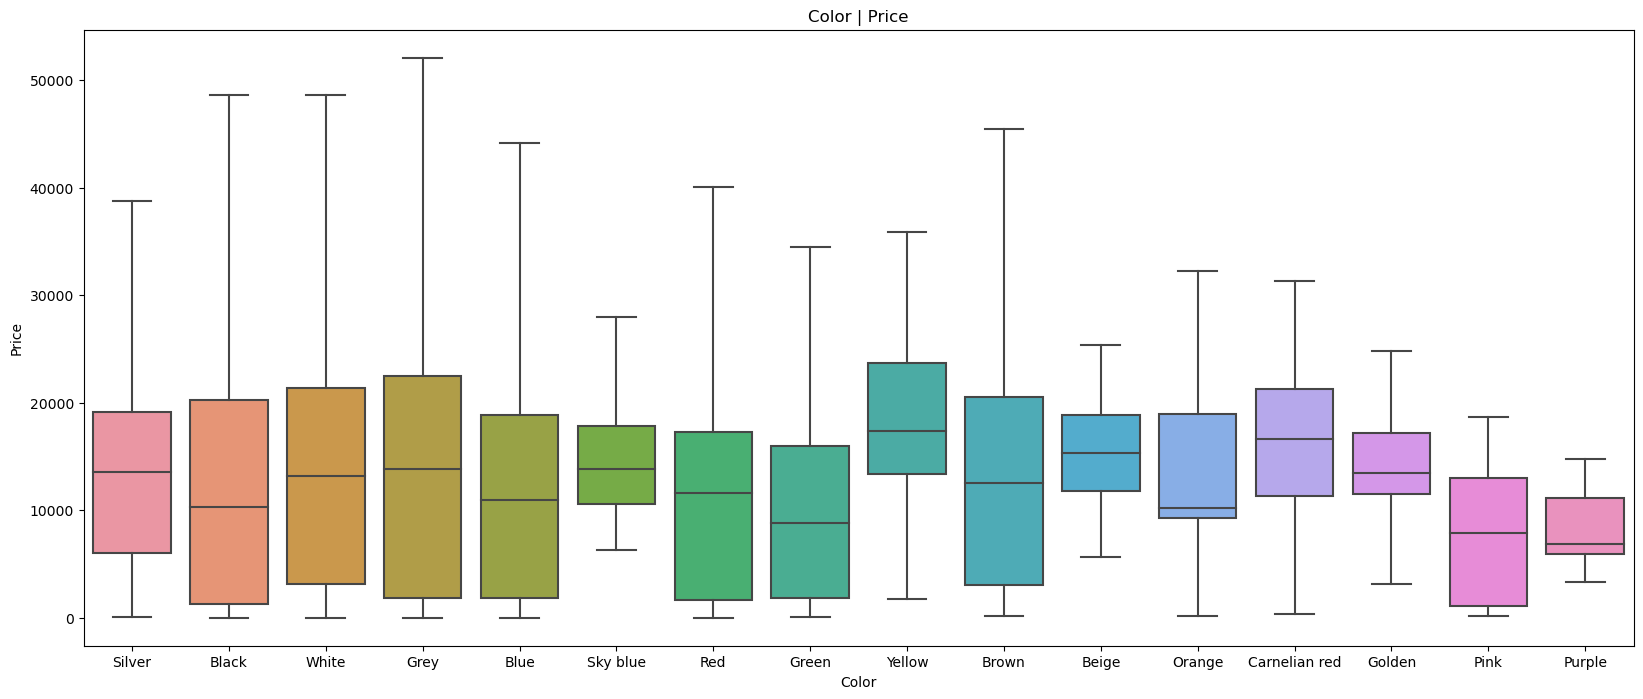

P-Value para variavel Exist_Turbo é:  {1.199210748774993e-35}


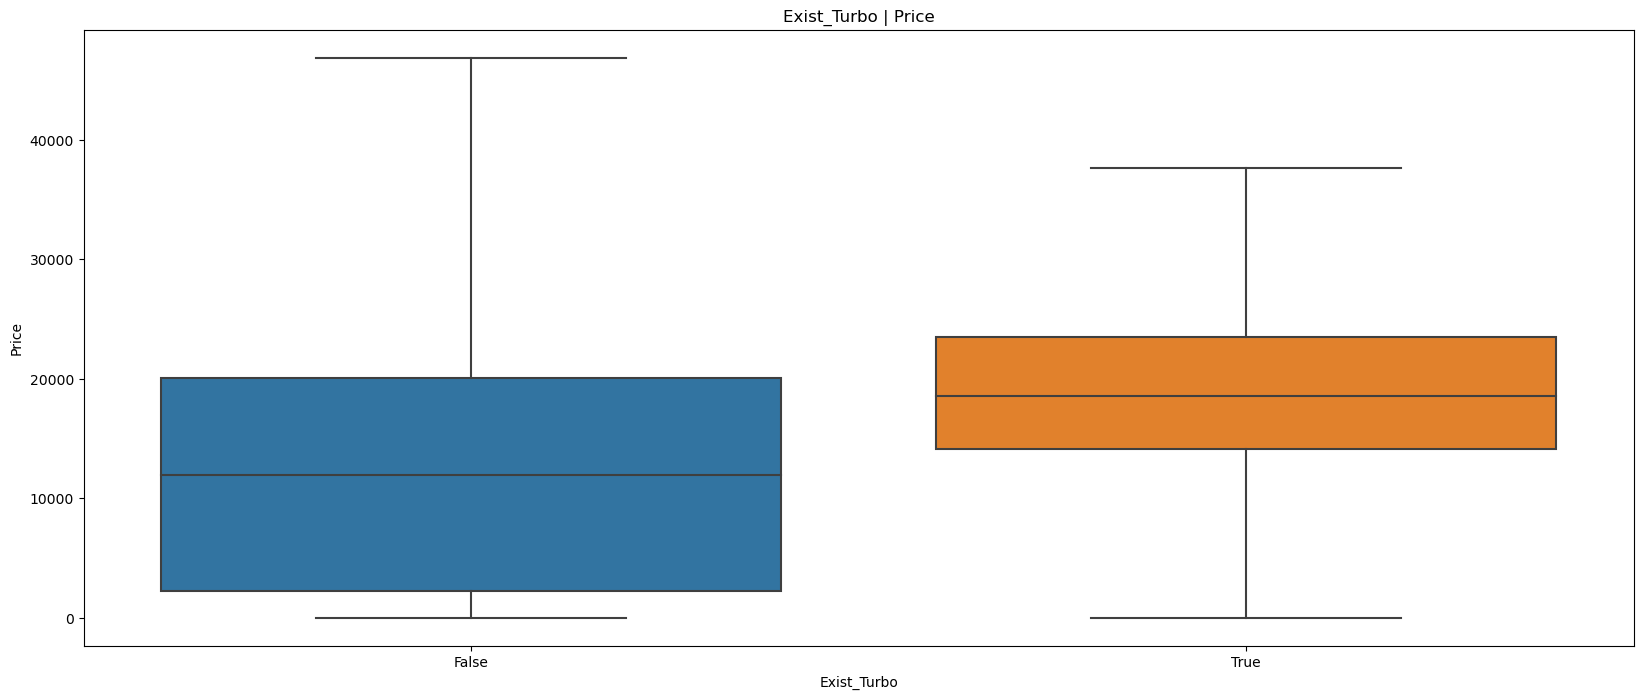

In [58]:
for col in cat_features:
    df = df_without_outliers_drop
    var = 'Price'
    # ANOVA
    category_group = df.groupby(col)[var].apply(list)
    anova = f_oneway(*category_group)
    print(f"P-Value para variavel {col} é: ",{anova[1]})
    # BOXPLOT
    plt.figure(figsize=(20,8))
    plt.title(f'{col} | {var}')
    sns.boxplot(data = df, x = col, y = var, showfliers = False);
    plt.show();

# Feature selection

In [59]:
features_selected = ['Price', 'Manufacturer', 'Prod_year', 'Category',
                        'Fuel_type', 'Mileage','Gear_box_type', 'Drive_wheels', 
                        'Wheel', 'Color', 'Airbags', 'Exist_Turbo', 'last_price']

In [60]:
df_features_selected = df_without_outliers_drop[features_selected]

In [61]:
df_features_selected.columns

Index(['Price', 'Manufacturer', 'Prod_year', 'Category', 'Fuel_type',
       'Mileage', 'Gear_box_type', 'Drive_wheels', 'Wheel', 'Color', 'Airbags',
       'Exist_Turbo', 'last_price'],
      dtype='object')

# Multicolinearidade

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def get_VIF(dataFrame , target):
    X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

target = 'Price'
print(get_VIF(df_features_selected.select_dtypes(['int64', 'float64']),target))

const         996257.431070
Prod_year          2.054348
Mileage            1.173596
Airbags            1.023432
last_price         1.999927
dtype: float64


# Dummies model

In [63]:
cat_columns = df_features_selected.select_dtypes(['object','category']).columns.to_list()

for col in cat_columns:
    print(f"{col} - {df_features_selected[cat_columns][col].nunique()}")

Manufacturer - 45
Category - 10
Fuel_type - 6
Gear_box_type - 4
Drive_wheels - 3
Wheel - 2
Color - 16


In [64]:
# Encode labels 
df_features_selected['Manufacturer']= le.fit_transform(df_features_selected['Manufacturer']) 
df_features_selected['Color']= le.fit_transform(df_features_selected['Color'])

# Outras colunas categóricas
df_model_dummies = pd.get_dummies(df_features_selected)

df_model_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11428 entries, 0 to 19236
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     11428 non-null  int64  
 1   Manufacturer              11428 non-null  int32  
 2   Prod_year                 11428 non-null  int64  
 3   Mileage                   11428 non-null  float64
 4   Color                     11428 non-null  int32  
 5   Airbags                   11428 non-null  int64  
 6   Exist_Turbo               11428 non-null  bool   
 7   last_price                11428 non-null  float64
 8   Category_Cabriolet        11428 non-null  uint8  
 9   Category_Coupe            11428 non-null  uint8  
 10  Category_Goods wagon      11428 non-null  uint8  
 11  Category_Hatchback        11428 non-null  uint8  
 12  Category_Jeep             11428 non-null  uint8  
 13  Category_Microbus         11428 non-null  uint8  
 14  Catego

C:\Users\a1788685\AppData\Local\Temp\ipykernel_14696\968246571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_selected['Manufacturer']= le.fit_transform(df_features_selected['Manufacturer'])
C:\Users\a1788685\AppData\Local\Temp\ipykernel_14696\968246571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_selected['Color']= le.fit_transform(df_features_selected['Color'])


# Normalize features

In [65]:
from sklearn.preprocessing import StandardScaler

col_nb = df_model_dummies.select_dtypes(['int64','float64']).columns.to_list()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model_dummies[col_nb])

df_normalize = df_model_dummies.copy()
df_normalize[col_nb] = scaled_data

# Modeling

## Split (Train | Test)

In [66]:
X = df_normalize.drop(columns=['Price'])
y = df_normalize['Price']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 42,
                                                    shuffle = True) 

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', len(y_train))
print('y_test:', len(y_test))

X_train: (7999, 32)
X_test: (3429, 32)
y_train: 7999
y_test: 3429


## Random Forest Regressor

### Tuning

In [92]:
n_estimators = [10,30,60,100,500,1000]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15,25,50]
min_samples_split = [5,10,20]
min_samples_leaf = [1,2,4]
bootstrap = ['True','False']

random_grid = {'n_estimators': n_estimators,
               'max_features':max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

rfr = RandomForestRegressor(random_state=42)
rfr_tuned = RandomizedSearchCV(estimator = rfr,
                               param_distributions=random_grid,
                               n_iter=100, 
                               cv=3,verbose=2,
                               n_jobs=-1,
                               random_state=42)
mdl_rfr = rfr_tuned.fit(X_train, y_train)
print(rfr_tuned.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 25, 'bootstrap': 'True'}


### Model

In [68]:
# Fit do modelo
rfr_tuned_final = RandomForestRegressor(n_estimators = 1000, 
                                min_samples_split = 5, 
                                max_features = 'auto', 
                                max_depth = 25,
                                bootstrap = 'True',
                                random_state = 42)

mdl_rfr_final = rfr_tuned_final.fit(X_train, y_train)

In [69]:
# Predição do teste
y_pred_rfr = mdl_rfr_final.predict(X_test)
y_true_rfr = y_test.tolist()

In [70]:
# Métricas de validação
r2_rfr = r2_score(y_true_rfr,y_pred_rfr)
rmse_rfr = mean_squared_error(y_true_rfr,y_pred_rfr)**(1/2)
mae_rfr = mean_absolute_error(y_true_rfr,y_pred_rfr)

### Plots

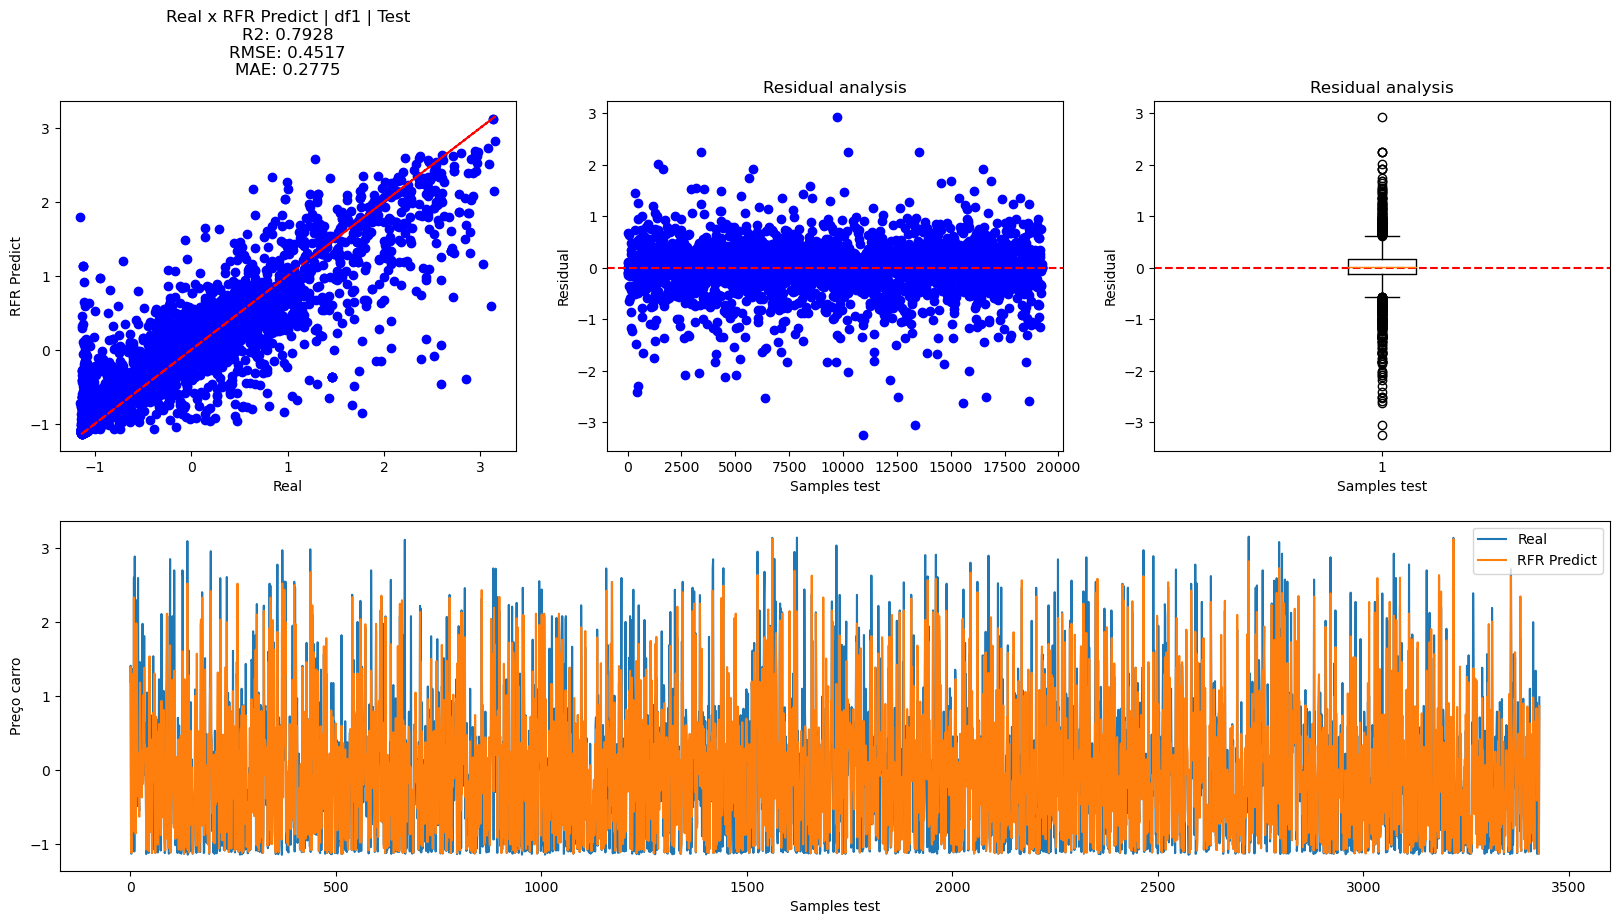

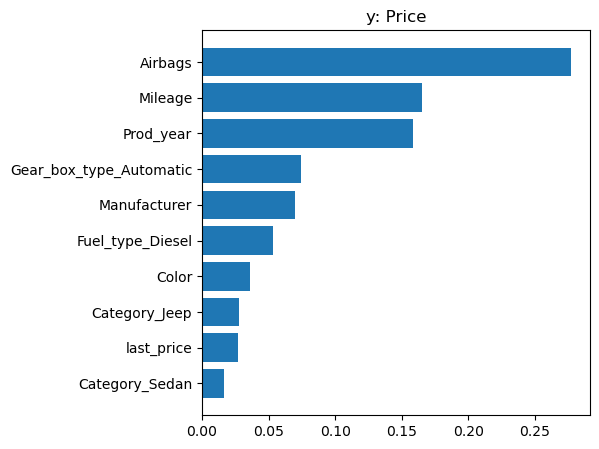

In [71]:
#Plots Modelo
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,(4,6))

axes = [ax1, ax2, ax3, ax4]

#Real x RFR Predict
ax1.scatter(x = y_true_rfr, y = y_pred_rfr, color = 'blue')
ax1.plot(y_true_rfr,y_true_rfr, color='r', ls='--')
ax1.set_xlabel('Real')
ax1.set_ylabel('RFR Predict')
#ax1.set_xlim(0,55)
#ax1.set_ylim(0,55)
ax1.set_title(f'Real x RFR Predict | df1 | Test\nR2: {r2_rfr:.4f}\nRMSE: {rmse_rfr:.4f}\nMAE: {mae_rfr:.4f}\n');

#Residual Analysis | RFR Predict | Scatter
error = (y_pred_rfr - y_true_rfr)#.reshape(-1,1)
ax2.scatter(X_test.index, error, color = 'blue')
ax2.axhline(y = 0, color = 'r', linestyle = '--')
ax2.set_title("Residual analysis")
#ax2.set_ylim(-10,10)
ax2.set_ylabel('Residual')
ax2.set_xlabel('Samples test');

#Residual Analysis | RFR Predict | Boxplot
error = (y_pred_rfr - y_true_rfr)#.reshape(-1,1)
ax3.boxplot(error)
ax3.axhline(y = 0, color = 'r', linestyle = '--')
ax3.set_title("Residual analysis")
#ax3.set_ylim(-10,10)
ax3.set_ylabel('Residual')
ax3.set_xlabel('Samples test');

#Real x RFR Predict - Timeline
ax4.plot(y_true_rfr,label='Real')
ax4.plot(y_pred_rfr,label='RFR Predict')
ax4.set_xlabel('Samples test')
ax4.set_ylabel('Preço carro')
ax4.legend();

#Feature Importance
rfr_importance = pd.DataFrame({'features': X_test.columns,'importance': mdl_rfr.best_estimator_.feature_importances_}).sort_values('importance',ascending=True)
rfr_importance = rfr_importance.tail(10)
plt.figure(figsize=(5,5))
plt.title(f'y: Price')
plt.barh(rfr_importance.features,rfr_importance.importance);
plt.show()

## ElasticNet Regression

In [72]:
from sklearn.linear_model import ElasticNet

### Tuning

In [73]:
# Tuning do modelo
from sklearn.linear_model import ElasticNetCV

results = ElasticNetCV(cv = 10).fit(X_train,y_train)

In [74]:
results.alpha_

0.0013199477789637567

### Model

In [75]:
# Let's create the final model according to optimum alpha.
enet_tuned = ElasticNet(alpha = results.alpha_).fit(X_train,y_train)

In [76]:
# Predict test data
y_pred_enet_tuned = enet_tuned.predict(X_test)
y_true_enet = y_test.tolist()

In [77]:
# Metrics RFR Predicts
r2_enet_tuned = r2_score(y_test,y_pred_enet_tuned)
rmse_enet_tuned = mean_squared_error(y_test,y_pred_enet_tuned)**(1/2)
mae_enet_tuned = mean_absolute_error(y_test,y_pred_enet_tuned)

### Plots

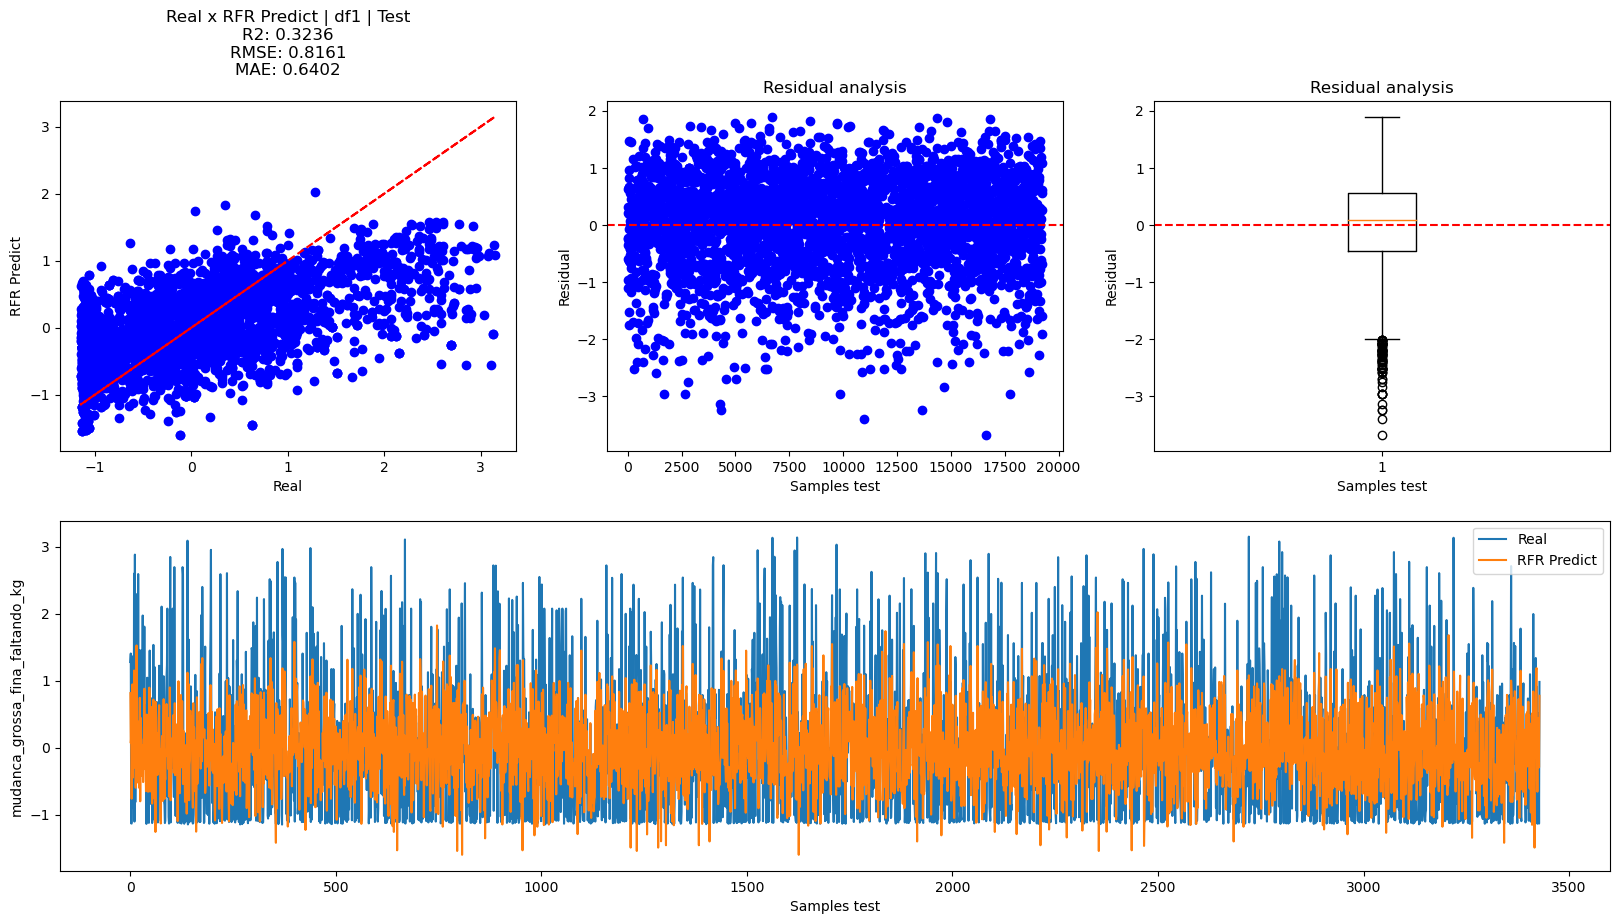

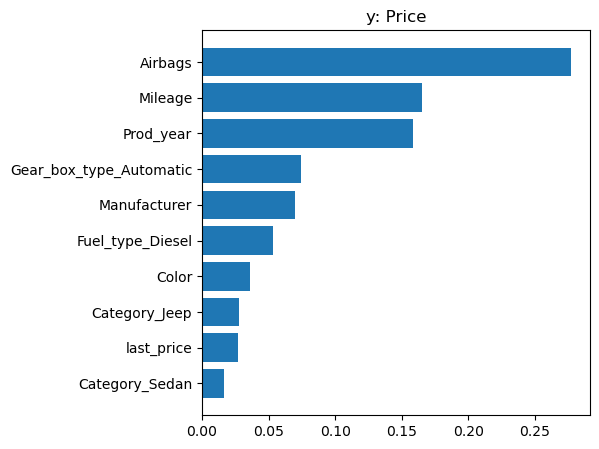

In [78]:
#Plots do Modelo
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,(4,6))

axes = [ax1, ax2, ax3, ax4]

#Real x RFR Predict
ax1.scatter(x = y_true_enet, y = y_pred_enet_tuned, color = 'blue')
ax1.plot(y_true_enet,y_true_enet, color='r', ls='--')
ax1.set_xlabel('Real')
ax1.set_ylabel('RFR Predict')
#ax1.set_xlim(0,55)
#ax1.set_ylim(0,55)
ax1.set_title(f'Real x RFR Predict | df1 | Test\nR2: {r2_enet_tuned:.4f}\nRMSE: {rmse_enet_tuned:.4f}\nMAE: {mae_enet_tuned:.4f}\n');

#Análise residual | RFR Predict | Scatter
error = (y_pred_enet_tuned - y_true_enet)#.reshape(-1,1)
ax2.scatter(X_test.index, error, color = 'blue')
ax2.axhline(y = 0, color = 'r', linestyle = '--')
ax2.set_title("Residual analysis")
#ax2.set_ylim(-10,10)
ax2.set_ylabel('Residual')
ax2.set_xlabel('Samples test');

#Análise residual | RFR Predict | Boxplot
error = (y_pred_enet_tuned - y_true_enet)#.reshape(-1,1)
ax3.boxplot(error)
ax3.axhline(y = 0, color = 'r', linestyle = '--')
ax3.set_title("Residual analysis")
#ax3.set_ylim(-10,10)
ax3.set_ylabel('Residual')
ax3.set_xlabel('Samples test');

#Real x RFR Predict - Timeline
ax4.plot(y_true_enet,label='Real')
ax4.plot(y_pred_enet_tuned,label='RFR Predict')
ax4.set_xlabel('Samples test')
ax4.set_ylabel('mudanca_grossa_fina_faltando_kg')
ax4.legend()

#Feature Importance
rfr_importance = pd.DataFrame({'features': X_test.columns,'importance': mdl_rfr.best_estimator_.feature_importances_}).sort_values('importance',ascending=True)
rfr_importance = rfr_importance.tail(10)
plt.figure(figsize=(5,5))
plt.title(f'y: Price')
plt.barh(rfr_importance.features,rfr_importance.importance);
plt.show()

## XGBRegressor

In [79]:
from xgboost import XGBRegressor

### Tuning

In [80]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
n_estimators = [10,30,60,100,500,1000]
max_depth = [6,10,15,25]
eta = [0.1,0.3,0.5]
subsample = [1,2,3,4]
colsample_bytree = [1,2,3]

param = {'max_depth':max_depth,
          'n_estimators': n_estimators,
          'eta': eta,
          'subsample': subsample,
          'colsample_bytree': colsample_bytree}

xb = XGBRegressor(random_state=42)
xb_tuned = RandomizedSearchCV(estimator = xb,
                               param_distributions=param,
                               n_iter=100, 
                               cv=3,
                               verbose=2,
                               n_jobs=-1,
                               random_state=42)
mdl_xb = xb_tuned.fit(X_train, y_train)
print(xb_tuned.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 1, 'n_estimators': 500, 'max_depth': 10, 'eta': 0.3, 'colsample_bytree': 1}


### Model

In [87]:
# Fit tuned model
xb_tuned_final = XGBRegressor(subsample = 1, 
                               n_estimators = 500, 
                               max_depth = 10, 
                               eta = 0.3, 
                               colsample_bytree = 1)

mdl_xb_final = xb_tuned_final.fit(X_train, y_train)

In [88]:
# Predict test data
y_pred_xb = mdl_xb_final.predict(X_test)
y_true_xb = y_test.tolist()

In [89]:
# Metrics RFR Predicts
r2_xb = r2_score(y_true_xb,y_pred_xb)
rmse_xb = mean_squared_error(y_true_xb,y_pred_xb)**(1/2)
mae_xb = mean_absolute_error(y_true_xb,y_pred_xb)

### Plots

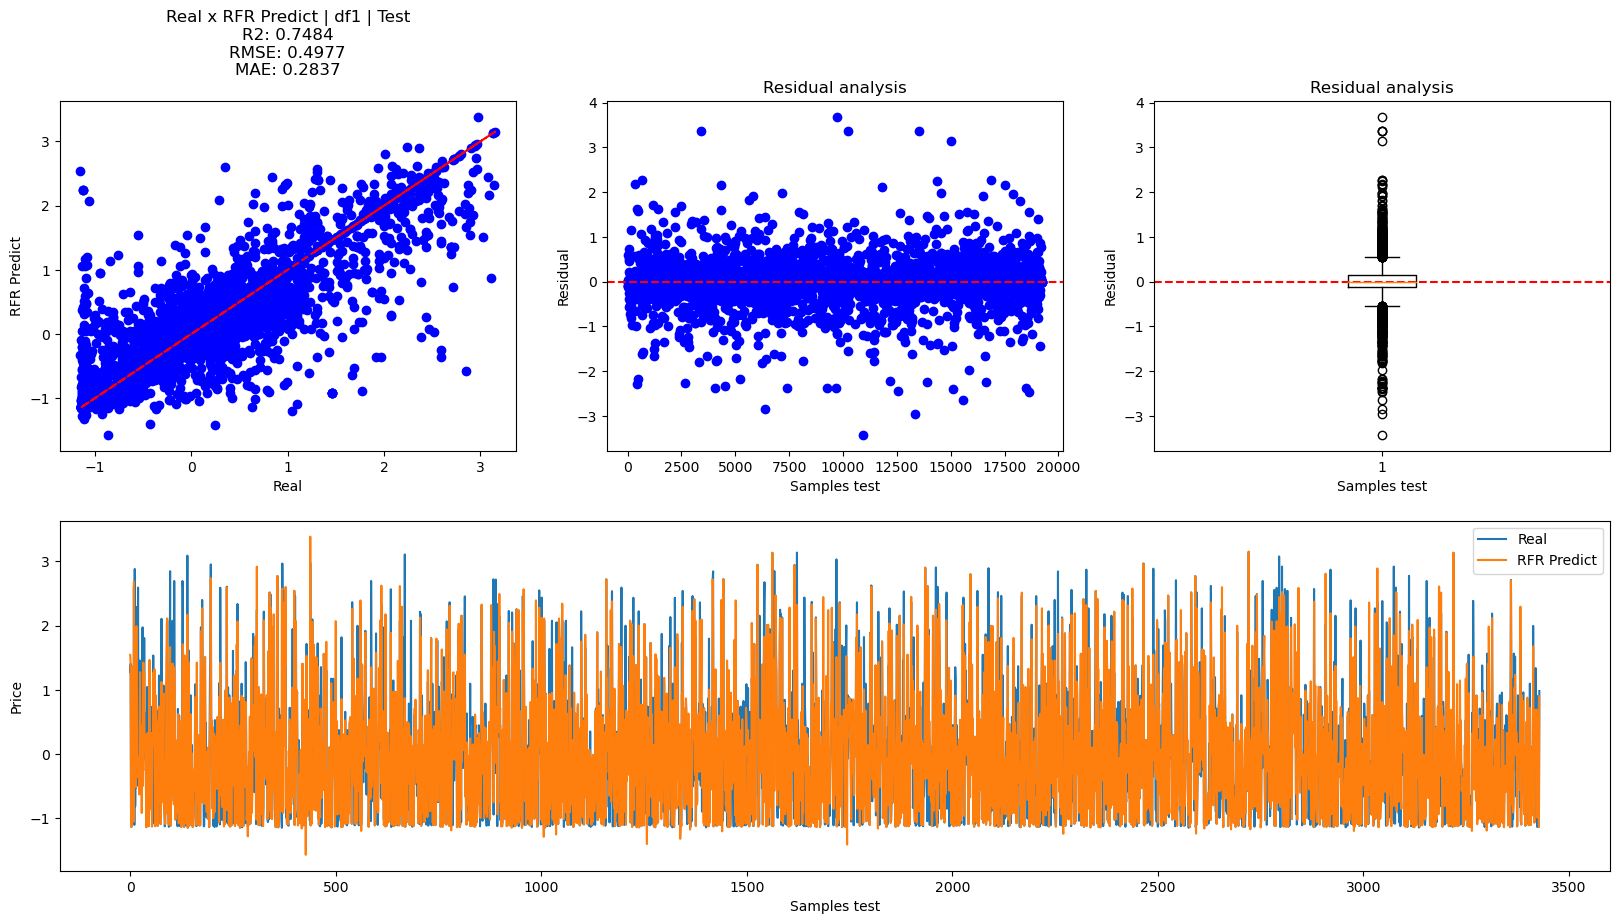

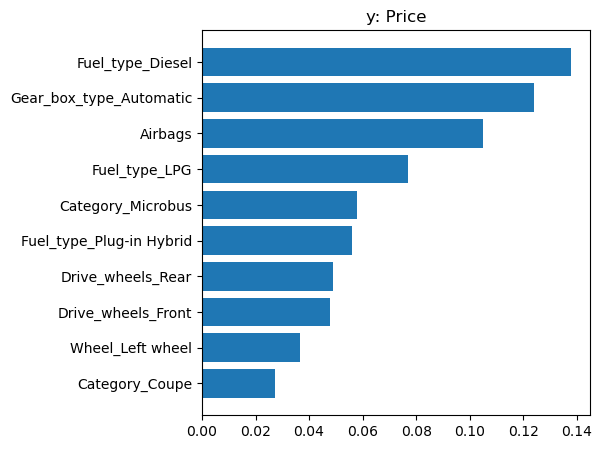

In [90]:
#Plots Modelo
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,(4,6))

axes = [ax1, ax2, ax3, ax4]

#Real x RFR Predict
ax1.scatter(x = y_true_xb, y = y_pred_xb, color = 'blue')
ax1.plot(y_true_xb,y_true_xb, color='r', ls='--')
ax1.set_xlabel('Real')
ax1.set_ylabel('RFR Predict')
#ax1.set_xlim(0,55)
#ax1.set_ylim(0,55)
ax1.set_title(f'Real x RFR Predict | df1 | Test\nR2: {r2_xb:.4f}\nRMSE: {rmse_xb:.4f}\nMAE: {mae_xb:.4f}\n');

#Residual Analysis | RFR Predict | Scatter
error = (y_pred_xb - y_true_xb)#.reshape(-1,1)
ax2.scatter(X_test.index, error, color = 'blue')
ax2.axhline(y = 0, color = 'r', linestyle = '--')
ax2.set_title("Residual analysis")
#ax2.set_ylim(-10,10)
ax2.set_ylabel('Residual')
ax2.set_xlabel('Samples test');

#Residual Analysis | RFR Predict | Boxplot
error = (y_pred_xb - y_true_xb)#.reshape(-1,1)
ax3.boxplot(error)
ax3.axhline(y = 0, color = 'r', linestyle = '--')
ax3.set_title("Residual analysis")
#ax3.set_ylim(-10,10)
ax3.set_ylabel('Residual')
ax3.set_xlabel('Samples test');


#Real x RFR Predict - Timeline
ax4.plot(y_true_xb,label='Real')
ax4.plot(y_pred_xb,label='RFR Predict')
ax4.set_xlabel('Samples test')
ax4.set_ylabel('Price')
ax4.legend();
#################################################################################################

#Feature Importance
xb_importance = pd.DataFrame({'features': X_test.columns,'importance': mdl_xb.best_estimator_.feature_importances_}).sort_values('importance',ascending=True)
xb_importance = xb_importance.tail(10)
plt.figure(figsize=(5,5))
plt.title(f'y: Price')
plt.barh(xb_importance.features,xb_importance.importance);
plt.show()